<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from IPython.display import clear_output
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
def get_dataloader(image_size, batch_size):

    root = 'D:/faces/'
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    dataset = ImageFolder(root, transform=tt.Compose([
        tt.Resize(image_size),
        tt.RandomHorizontalFlip(p=0.5),
        tt.ToTensor(),
        tt.Normalize(*stats)
    ]))

    dataloader = DataLoader(dataset, batch_size,shuffle=True, num_workers=4, pin_memory=True)

#   """
#   Builds dataloader for training data.
#   Use tt.Compose and tt.Resize for transformations
#   :param image_size: height and wdith of the image
#   :param batch_size: batch_size of the dataloader
#   :returns: DataLoader object 
#   """
    return dataloader
  # TODO: resize images, convert them to tensors and build dataloader

In [5]:
image_size = 64
batch_size = 128

#TODO: build dataloader and transfer it to device


In [6]:
dl = get_dataloader(image_size, batch_size)

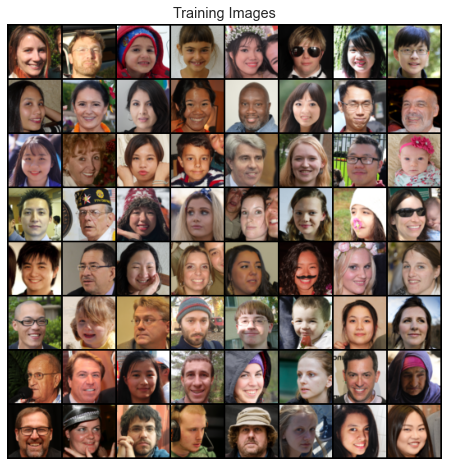

In [7]:
# Plot some training images
real_batch = next(iter(dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [8]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ), # 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # 4 x 4
            nn.Conv2d(features_d*8, 1, 4, 2, 0), # 1 x 1
            nn.Sigmoid()
            
        )
    
    
    def _block(self, in_channels, out_chanels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_chanels, 
                kernel_size, 
                stride,
                padding,
                bias = False
            ),
            nn.BatchNorm2d(out_chanels),
            nn.LeakyReLU(0.2)
        )
    def forward (self, x):
            return self.disc(x)
        

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x features_g*16 x 4 x4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8 x 8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32 x 32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh() #[-1, 1]
            
        
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride, 
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.gen(x)

In [10]:
def weights(model):
    for i in model.modules():
        if isinstance(i, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(i.weight.data, 0.0, 0.02)
            
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    weights(disc)
    try:        
        assert disc(x).shape == (N, 1, 1, 1)
        print('GOOD_DISCRIMINATOR')
    except:
        print('SUCK_DISCRIMINATOR')
    gen = Generator(z_dim, in_channels, 8)
    weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    try:
        assert gen(z).shape == (N, in_channels, H, W)
        print('GOOD_GENERATOR')
    except:
        print('BAD_GENERATOR')
        print(gen(x).shape, (N, in_channels, H, W))
        
            

In [11]:
test()

GOOD_DISCRIMINATOR
GOOD_GENERATOR


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_g = 0.0002
lr_d = 0.0001
channels_img = 3
latent_size = 100

feachures_disk = 64
features_gen = 64

In [13]:
gen = Generator(latent_size, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, feachures_disk).to(device)
weights(gen)
weights(disc)

In [14]:
opt_gen = optim.Adam(gen.parameters(),lr=lr_g, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [15]:
noise = torch.randn(32, latent_size, 1, 1).to(device)

In [16]:
def plot_loss(G_loss, D_loss):
#     plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

In [17]:

# # img_list = []
# # G_losses = []
# # D_losses = []

# G_losses = list(np.load('./G_losses.npy'))
# D_losses = list(np.load('./D_losses.npy'))

# gen = torch.load('./gen')
# disc = torch.load('./disc')

# epochs = 300
# gen.train()
# disc.train()

# for epoch in tqdm(range(epochs)):
#     for idx, data in enumerate(dl):
#         real = data[0].to(device)
#         noise = torch.randn((batch_size, latent_size, 1, 1)).to(device)
#         fake = gen(noise)
        
#         ### Train Discriminator  max log(D(x) + log(1 - D(G(z)))
#         disc_real = disc(real).view(-1) 
#         loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
#         disc_fake = disc(fake).view(-1)
#         loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
#         loss_disc = (loss_disc_real + loss_disc_fake) / 2
#         disc.zero_grad()
#         loss_disc.backward(retain_graph=True)
#         opt_disc.step()
        
#         ### Train Generator min log(1 - D(G(z))) <-> max log(D(G(z))
#         output = disc(fake).view(-1)
#         loss_gen = criterion(output, torch.ones_like(output))
#         gen.zero_grad()
#         loss_gen.backward()
#         opt_gen.step()
        
#         G_losses.append(loss_gen.item())
#         D_losses.append(loss_disc.item())
        
#         # Check how the generator is doing by saving G's output on fixed_noise
# #         if (epoch % 5 == 0) or ((epoch == epochs-1) and (idx == len(dl)-1)):

            
        
#         ### Print
#         if idx % 1000 == 0 or ((epoch == epochs-1) and (idx == len(dl)-1)):
#             clear_output()
#             print(
#                 f'[{epoch}/{epochs}] Batch {idx}/{len(dl)} \
#                 Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}'
#             )
                        
#             with torch.no_grad():
#                 fk = gen(noise).detach().cpu()
#             img_to_plot = vutils.make_grid(fk, padding=2, normalize=True)
# #             img_list.append(vutils.make_grid(fk, padding=2, normalize=True)) 
            
#             torch.save(gen, './gen')
#             torch.save(disc, './disc')
#             np.save('./G_losses.npy', G_losses)
#             np.save('./D_losses.npy', D_losses)
#             np.save('./img.npy', img_to_plot)
            
            
            

#             fig = plt.figure(figsize=(18,8))
#             plt.axis("off")
#             plt.subplot(1, 2, 1)
#             [plt.imshow(np.transpose(img_to_plot,(1,2,0)), animated=False)][-1]
#             plt.subplot(1, 2, 2)
#             plot_loss(G_losses, D_losses)
#             plt.show();            
            


In [18]:
G_losses = list(np.load('./G_losses.npy'))
D_losses = list(np.load('./D_losses.npy'))

gen = torch.load('./gen')
disc = torch.load('./disc')

In [19]:
# np.load('./D_losses.npy')

In [20]:
# np.load('./G_losses.npy')

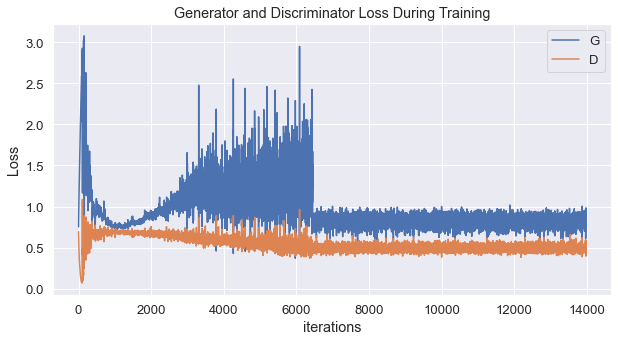

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Лоссы генератора и дискриминатора выровнялись. Думаю, это неплохой результат, для урезанного датасета

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

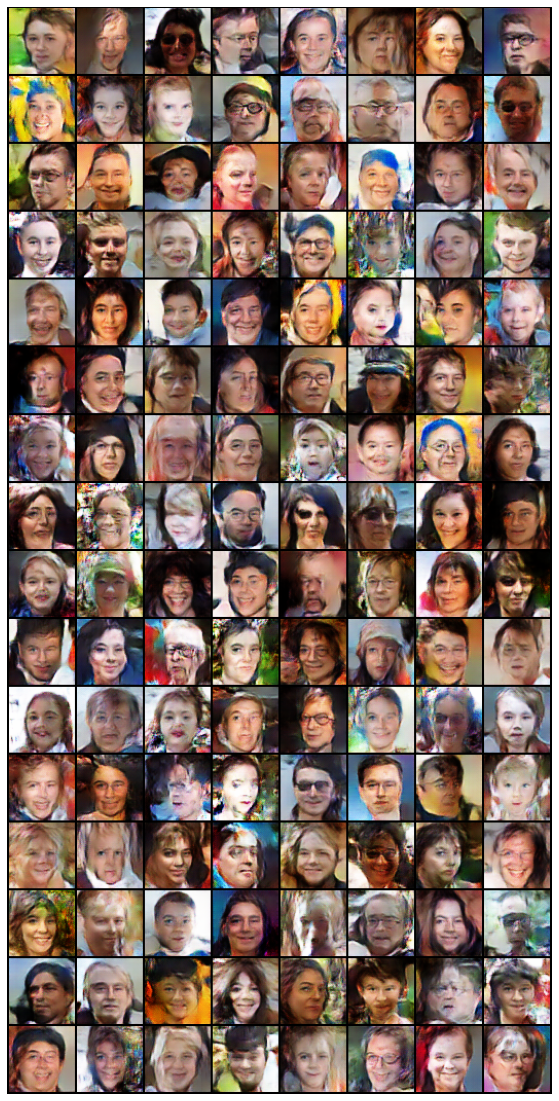

In [22]:
img_to_plot = torch.tensor(np.load('./img.npy'))# Saved last picture

plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(np.transpose(img_to_plot,(1,2,0)))

In [23]:
def show_images(generated):
    img = vutils.make_grid(generated, padding=2, normalize=True)
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()
    
    
 

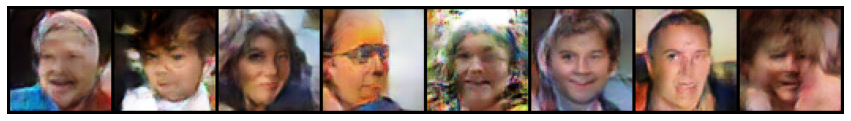

In [24]:
n_images = 8
noise = torch.randn(n_images, latent_size, 1, 1, device=device)
fake = gen(noise).detach().cpu()
show_images(fake)
torch.cuda.empty_cache()

Как вам качество получившихся изображений?

Если использовать полный датасет, думаю, будет лучше

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [25]:
# Генерируем изображения

def gen_img(n_img):
    for i in range(n_img):
        noise = torch.randn(1, latent_size, 1, 1, device=device)
        fake = gen(noise)
        save_image(fake,f'D:/fake/fake/{i}.png', normalize=True)
        torch.cuda.empty_cache()

In [26]:
gen_img(3143)

In [27]:
root = 'D:/fake/'
dataset_fake = ImageFolder(root, transform=tt.Compose([
        tt.ToTensor()
    ]))
dl_fake = DataLoader(dataset_fake, batch_size, num_workers=4, pin_memory=True)

In [28]:
root = 'D:/faces/'
dataset_true = ImageFolder(root, transform=tt.Compose([
        tt.Resize(64),
        tt.ToTensor()
    ]))
dl_true = DataLoader(dataset_true, batch_size, num_workers=4, pin_memory=True)

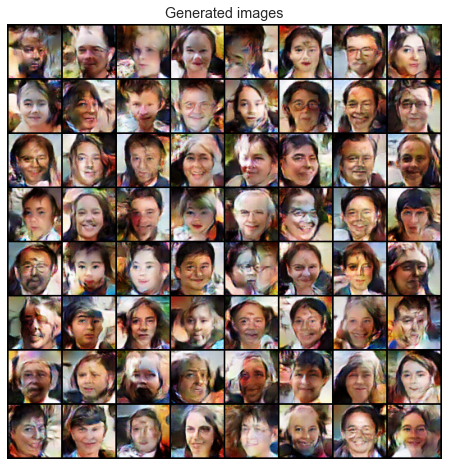

In [29]:
# Plot some generated images
fake_batch = next(iter(dl_fake))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0][:64], padding=2, normalize=False).cpu(),(1,2,0)))

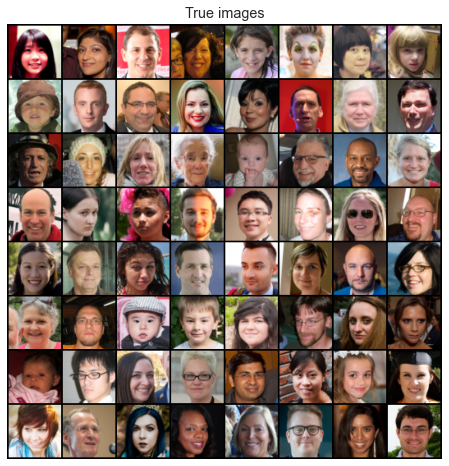

In [30]:
# Plot some true images
real_batch = next(iter(dl_true))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("True images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=False).cpu(),(1,2,0)))

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
import pandas as pd
from sklearn.metrics import accuracy_score

In [32]:
def get_img_list(dataloader):
    flatten_imgs = []
    for i in dataloader:
        for j in i[0]: 
            flatten_imgs.append(np.array(j.flatten()))
    return np.array(flatten_imgs)
    

In [33]:
X_fake = get_img_list(dl_fake) 
X_true = get_img_list(dl_true)

In [34]:
y_fake = np.full(len(X_fake),0)
y_true = np.full(len(X_true),1)

In [35]:
X = np.concatenate((X_fake, X_true))
y = np.concatenate((y_fake, y_true))

In [36]:
loo = LeaveOneOut()

In [37]:
# loo.get_n_splits(X)

In [38]:
# X[:3].shape

In [39]:
# predicts = []
# true = []
# for train_idx, test_idx in tqdm(loo.split(X)):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     print(X_train.shape, X_test.shape)
#     print(y_train.shape, y_test.shape)
#     knn = KNeighborsClassifier(n_neighbors=1)
#     knn.fit(X_train,y_train)
#     y_pred = knn.predict(knn.predict(X_test))
#     predicts.append(y_pred)
#     true.append(y_test)
    


In [40]:
# np.unique(predicts, return_counts=True)

In [41]:
# np.unique(y_true, return_counts=True)

In [42]:
# print(f'Accuracy {accuracy_score(true, predicts)}')

In [44]:
knn = KNeighborsClassifier(n_neighbors=1)

In [45]:
model = cross_val_score(knn, X, y, cv=loo, verbose=1, n_jobs=-1, scoring='accuracy')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 6286 out of 6286 | elapsed: 25.0min finished


In [51]:
scores = model
print('Accuracy: %.3f ' % (np.mean(scores)))

Accuracy: 0.781 


Мы получили результат не самый лучший. Хотелось бы 0.5

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [54]:
from sklearn.manifold import TSNE
import plotly.express as px

Прокомментируйте получившийся результат:

In [56]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

In [57]:
fig = px.scatter(tsne_results,
                 x=0,
                 y=1,
                 color=y,
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

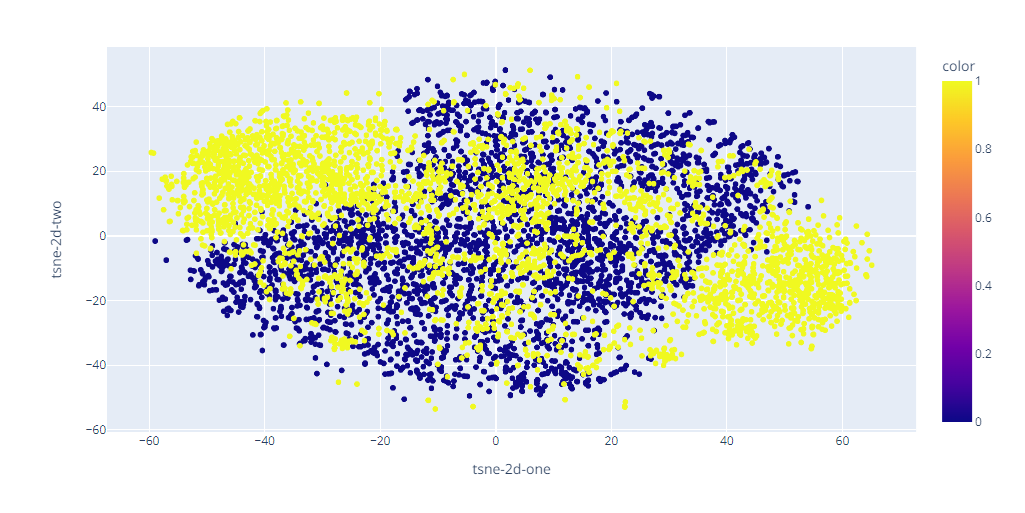

Данные смешаны, но недостаточно хорошо. В лучшем варианте не должно быть явно выраженных областей.